# Monitor coupling in M1M3 VMS system and TMA drives together

* This notebook is associated to [SITCOM-784](https://rubinobs.atlassian.net/browse/SITCOM-784)
* It contains the analysis associated to the Technical Note: SITCOMTN-131

The M1M3 and the TMA control systems might affect each other. Vibrations in the control loop of one of them might introduce vibration modes in the control loop of the other.

If these new vibrations are too large, M1M3 will protect itself. The TMA should also protect itself. This means that they would go to a fault immediately if the coupling is too strong.

However, even if they are not strong enough, we still need to capture them and characterize the effects one can have on the other. For that, we need to get the telemetry from M1M3 VMS and the telemetry (maybe the drives positions?) from the TMA, synchronize them and look for coupling in both signals. 

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

%load_ext lab_black

In [3]:
import os.path

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import h5py
import numpy as np

from astropy.time import Time
from astropy.time import TimeDelta
from astropy import units as u
import matplotlib.dates as mdates
from matplotlib.ticker import FormatStrFormatter
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from matplotlib import ticker
from scipy.signal import stft
from scipy.signal import find_peaks_cwt
from scipy import signal
from scipy.fft import fft, rfft, fftfreq, rfftfreq


from lsst_efd_client import EfdClient
from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState, TMAEvent
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient, getSubTopics
from lsst.ts.xml.enums import MTM1M3, MTMount

In [4]:
# Utility functions
key_m1m3_dict = {
    "1 X": "m1m3_x_1",
    "1 Y": "m1m3_y_1",
    "1 Z": "m1m3_z_1",
    "2 X": "m1m3_x_2",
    "2 Y": "m1m3_z_2",  # note these two have been
    "2 Z": "m1m3_y_2",  # switched pending SUMMIT-7911
    "3 X": "m1m3_x_3",
    "3 Y": "m1m3_y_3",
    "3 Z": "m1m3_z_3",
}
key_m2_dict = {
    "1 X": "m2_x_1",
    "1 Y": "m2_y_1",
    "1 Z": "m2_z_1",
    "2 X": "m2_x_2",
    "2 Y": "m2_z_2",
    "2 Z": "m2_y_2",
    "3 X": "m2_x_3",
    "3 Y": "m2_z_3",
    "3 Z": "m2_y_3",
    "4 X": "m2_x_4",
    "4 Y": "m2_y_4",
    "4 Z": "m2_z_4",
    "5 X": "m2_x_5",
    "5 Y": "m2_z_5",
    "5 Z": "m2_y_5",
    "6 X": "m2_x_6",
    "6 Y": "m2_z_6",
    "6 Z": "m2_y_6",
}


def vms_data_to_pandas(filename, vms_type, begin_time=None, end_time=None):
    """
    Converts VMS data in the given HDF5 file to a Pandas DataFrame.

    Args:
    filename: Path to the HDF5 file containing the VMS data.
    vms_type: The type of VMS data in the file. Must be "m1m3", "m2", or
      "rotator".
    begin_time: The start time of the data to include in the DataFrame. If None,
      all data will be included.
    end_time: The end time of the data to include in the DataFrame. If None, all
      data will be included.

    Returns:
    A Pandas DataFrame containing the VMS data.
    """
    if vms_type == "m1m3":
        key_dict = key_m1m3_dict
    elif vms_type == "m2":
        key_dict = key_m2_dict
    elif vms_type == "rotator":
        raise NotImplementedError
    else:
        raise ValueError("vms_type must be m1m3,m2, or rotator")

    f = h5py.File(filename, "r")
    times = f["timestamp"][::1]
    dkeys = "XYZ"

    data_dict = {}
    if (begin_time is not None) & (end_time is not None):
        sel = (times > begin_time) & (times < end_time)
    else:
        sel = np.ones(times.size).astype(bool)
    data_dict["times"] = times[sel]
    for key in key_dict.keys():
        # multiply values stored in hdf5 files by 2 in order to convert the acceleration values to mg
        data_dict[key_dict[key]] = f[key][::1][sel] * 2.0
    data_frame = pd.DataFrame(data_dict)
    for j in np.arange(int(len(key_dict) / 3)) + 1:
        data_frame[f"total_{j}"] = np.linalg.norm(
            data_frame[[f"{vms_type}_{i}_{j}" for i in ["x", "y", "z"]]].values, axis=1
        )

    return data_frame


def get_freq_psd(vals, timestep):
    """
    Calculates the frequency power spectrum of a signal.

    Args:
        vals (np.array): The signal values.
        timestep (float): The time step between samples.

    Returns:
        tuple: The frequencies and power spectral density.
    """

    # Remove the mean from the signal.

    meanval = np.mean(vals)
    signal = vals - meanval

    # Calculate the length of the signal.

    N = len(signal)

    # Calculate the power spectral density.

    psd = np.abs(np.fft.rfft(np.array(signal) * 1)) ** 2

    # Calculate the frequencies.

    frequencies = np.fft.rfftfreq(N, timestep)
    return (frequencies, psd)


def get_psd_and_dsd_for_vms(vals, timestep, min_freq=1, g=False):
    """
    Calculate the PSD and DSD from VMS data, and total displacement from DSD.

    Parameters:
    - vals (array-like): VMs in m/s^2 or milli-g if 'g' is True.
    - timestep (float): Time step between measurements in seconds.
    - min_freq (float, optional): Minimum frequency for calculations.
                                  Default is 1 Hz.
    - g (bool, optional): True if 'vals' are in milli-g units.
                          Default is False.

    Returns:
    - psds_df (DataFrame): DataFrame with frequencies ('freq'), acceleration
                           PSD ('accel_psd'), displacement PSD ('disp_psd'),
                           and cumulative displacement PSD ('int_disp').
    - total_displacement (float): Total displacement from vibration data.

    Note:
    PSD adjusted to m/s^2/Hz. 'vals' converted to m/s^2 if 'g' is True.
    """
    if g:
        vals = 1e-3 * 9.8 * vals

    # freq, accel_psd = signal.periodogram(vals, 1/timestep)
    # print("using scipy")
    freq, accel_psd = get_freq_psd(vals, timestep)

    sel = freq > min_freq
    freq = freq[sel]
    accel_psd = accel_psd[sel]

    accel_psd = accel_psd * np.mean(np.diff(freq))

    disp_psd_sq = accel_psd / ((2 * np.pi * freq) ** 4)

    int_displace_psd = np.sqrt(np.cumsum(disp_psd_sq))
    total_displacement = np.sqrt(np.sum(disp_psd_sq))

    psds_df = pd.DataFrame(
        {
            "freq": freq,
            "accel_psd": accel_psd,
            "disp_psd": np.sqrt(disp_psd_sq),
            "int_disp": int_displace_psd,
        }
    )

    return psds_df, total_displacement

In [5]:
# Create a directory to save plots
plot_dir = "./plots"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [39]:
# Acquisition date of VMS data
vms_date = "2023-12-21"

vms_top_dir = "/sdf/scratch/users/b/boutigny/vmsdata"
year, month = vms_date.split("-")[0:2]

# Directory containing VMS data
vms_dir = os.path.join("/scratch/users/b/boutigny/vmsdata", year, month)

# Check if a parquet file exists
# If yes, we read the pandas dataframe directly from it
# If not, we read the hdf file and re-create the pandas dataframe
vms_m1m3_parquet_filename = os.path.join(vms_dir, "M1M3-" + vms_date + "T00:00.parquet")
if os.path.isfile(vms_m1m3_parquet_filename):
    print(f"Reading VMS data from parquet file:{vms_m1m3_parquet_filename}")
    vms_m1m3_data = pd.read_parquet(vms_m1m3_parquet_filename)
else:
    vms_m1m3_hdf_filename = os.path.join(vms_dir, "M1M3-" + vms_date + "T00:00.hdf")
    print(f"Reading VMS data from hdf5 file:{vms_m1m3_hdf_filename}")
    vms_m1m3_data = vms_data_to_pandas(vms_m1m3_hdf_filename, vms_type="m1m3")
    # Remove entries with null timestamps
    vms_m1m3_data = vms_m1m3_data[vms_m1m3_data["times"] > 0]
    # Reformat timestamps
    vms_m1m3_data["times"] = Time(vms_m1m3_data["times"], format="unix").datetime

Reading VMS data from parquet file:/scratch/users/b/boutigny/vmsdata/2023/12/M1M3-2023-12-21T00:00.parquet


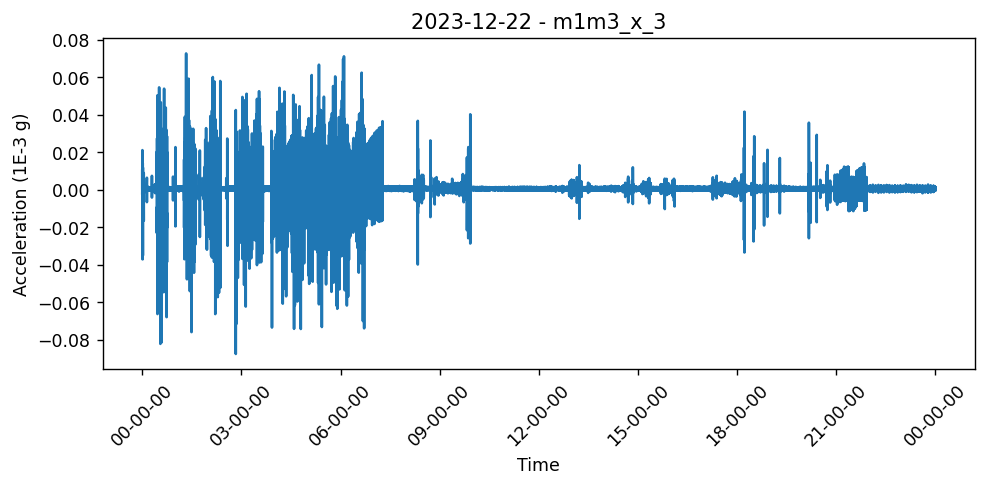

In [7]:
%matplotlib inline
# First look at the raw VMS data - We plot only 1 sensor and 1 axis because the full dataset is very large and requires too much memory
# to be displayed
fig, ax = plt.subplots(1, 1, dpi=125, figsize=(8, 4))
key = "m1m3_x_3"
ax.plot(vms_m1m3_data["times"], vms_m1m3_data[key])
ax.set(ylabel="Acceleration (1E-3 g)", xlabel="Time", title=f"{vms_date} - {key}")
ax.xaxis.set_major_formatter(DateFormatter("%H-%M-%S"))
plt.setp(ax.get_xticklabels(), rotation=45)
fig.tight_layout()
fig.savefig(f"{plot_dir}/VMS-accel-{vms_date}.png")

In [40]:
# Retrieve TMA events corresponding to the VMS acquisition date
# As VMS and TMA do not cover the same time window, we need to get the TMA events corresponding to both
# dayObs and the day before dayObs
dayObs = int(vms_date.replace("-", "", 2))
vms_time = Time(vms_date + "T00:00:00")
delta_t = TimeDelta(1, format="jd")
day_before = int(str(vms_time - delta_t)[0:10].replace("-", "", 2))
eventMaker = TMAEventMaker()
events = eventMaker.getEvents(day_before)
events = events + eventMaker.getEvents(dayObs)

# Get lists of slew events
slews = [e for e in events if e.type == TMAState.SLEWING]
print(f"Found {len(slews)} slews")

Found 1074 slews


In [41]:
# Filter the list of slews in order to keep the ones that are fully contained within the day corresponding to the VMS file.
date_min = Time(f"{vms_date} 00:00:00.00").unix
date_end = Time(f"{vms_date} 23:59:59.00").unix
sel_slews = [
    slews[i]
    for i in range(len(slews))
    if (slews[i].begin.unix > date_min and slews[i].end.unix < date_end)
]
print(f"Selected {len(sel_slews)} slews out of {len(slews)} for {dayObs}")

Selected 564 slews out of 1074 for 20231221


In [42]:
# Check that all the selected slews fall within dayObs
print(sel_slews[0].begin.datetime64, sel_slews[-1].end.datetime64)

2023-12-21T00:00:03.703244209 2023-12-21T23:59:41.575333118


In [43]:
client = EfdClient("usdf_efd")

In [44]:
# Print slews amplitudes and speed in azimuth and elevation
# This is intended to help selecting large slews that will be studied in details
# The selected slew numbers will be stored in variables slew_azi and slew_ele
# by default they contain the slews with the largest amplitudes
max_delta_azi = -99
max_delta_ele = -99
for i_slew, slew in enumerate(sel_slews):
    df_ele = getEfdData(client, "lsst.sal.MTMount.elevation", event=slew)
    df_azi = getEfdData(client, "lsst.sal.MTMount.azimuth", event=slew)

    t1 = slew.begin.datetime64
    t2 = slew.end.datetime64
    if len(df_ele) > 0:
        slew_delta_ele = df_ele["actualPosition"].max() - df_ele["actualPosition"].min()
        if slew_delta_ele > 30:
            print(
                f"Slew number: {i_slew} - Delta ele: {slew_delta_ele:.1f} degrees - Speed: {abs(df_ele['actualVelocity']).max()}",
                df_ele["actualPosition"].min(),
                df_ele["actualPosition"].max(),
            )
        if slew_delta_ele > max_delta_ele:
            max_delta_ele = slew_delta_ele
            slew_ele = i_slew
    if len(df_azi) > 0:
        slew_delta_azi = df_azi["actualPosition"].max() - df_azi["actualPosition"].min()
        if slew_delta_azi > 30:
            print(
                f"Slew number: {i_slew} - Delta azi: {slew_delta_azi:.1f} degrees - Speed: {abs(df_azi['actualVelocity']).max()}",
                df_azi["actualPosition"].min(),
                df_azi["actualPosition"].max(),
            )
        if slew_delta_azi > max_delta_azi:
            max_delta_azi = slew_delta_azi
            slew_azi = i_slew
print(
    f"Maximum amplitude slew in azimuth: {slew_azi} / {max_delta_azi:.1f} degrees - in elevation: {slew_ele} / {max_delta_ele:.1f} degrees"
)

Slew number: 22 - Delta azi: 52.0 degrees - Speed: 0.000878892108646331 -52.0073039946512 0.0


Slew number: 28 - Delta azi: 63.3 degrees - Speed: 6.9975115170657 -130.565209674233 -67.2313649737505
Slew number: 29 - Delta azi: 262.9 degrees - Speed: 7.01384610232146 -127.132413717317 135.71937414855
Slew number: 62 - Delta azi: 88.9 degrees - Speed: 7.01587108739295 44.2775164537955 133.185619713411


Slew number: 100 - Delta azi: 136.6 degrees - Speed: 7.0104243854145 -120.582370752087 16.0277365358522
Slew number: 134 - Delta azi: 108.1 degrees - Speed: 6.99813424967301 -113.898699205367 -5.84155413129526
Slew number: 167 - Delta azi: 105.9 degrees - Speed: 7.00522832226416 -119.405693039714 -13.4907882744964
Slew number: 168 - Delta azi: 106.8 degrees - Speed: 6.99932892463535 -119.644052036628 -12.8637690564087
Slew number: 234 - Delta azi: 96.3 degrees - Speed: 7.00306421607963 -14.3147020590773 81.9597359982894


Slew number: 241 - Delta azi: 77.3 degrees - Speed: 0.000647023587520968 0.0 77.2613952976665
Slew number: 245 - Delta azi: 72.0 degrees - Speed: 4.00396966266941 0.0203935523767155 72.007168215397
Slew number: 299 - Delta ele: 54.0 degrees - Speed: 2.00560115610784 27.9999997322439 81.9905963585379
Slew number: 422 - Delta azi: 153.0 degrees - Speed: 4.00295496185467 -8.36934975545927e-09 152.976693051758
Slew number: 457 - Delta ele: 40.0 degrees - Speed: 0.503576293116318 43.0247440239534 83.000004491866
Slew number: 457 - Delta azi: 118.0 degrees - Speed: 1.0041817119658 35.0299754833027 153.000014278856


Slew number: 546 - Delta ele: 62.0 degrees - Speed: 2.00434714279949 19.9999996593601 81.9886284524398
Slew number: 557 - Delta ele: 37.0 degrees - Speed: 2.00479160321455 44.9999926982063 82.0000013769098
Slew number: 557 - Delta azi: 100.0 degrees - Speed: 4.00937330334385 -99.9793903252568 1.12091868010462e-07
Slew number: 558 - Delta azi: 200.0 degrees - Speed: 4.01159040805884 -100.000000081316 99.9835380854667
Slew number: 559 - Delta azi: 200.0 degrees - Speed: 4.00859378347424 -99.9690053338928 100.000000302187
Slew number: 560 - Delta azi: 200.0 degrees - Speed: 4.00744437807185 -100.000000493159 99.979660036973
Slew number: 561 - Delta azi: 200.0 degrees - Speed: 4.00722244677762 -99.9788452630911 99.9999999554888
Slew number: 562 - Delta azi: 90.0 degrees - Speed: 4.005274751195 -100.000000216021 -10.0170951041642
Maximum amplitude slew in azimuth: 29 / 262.9 degrees - in elevation: 546 / 62.0 degrees


In [45]:
# This is the slew that we are going to analyze
# slew_select = slew_azi
slew_select = 558

# Add a small delta_t before and after the selected slew
delta_t = TimeDelta(5, format="sec")
start_slew = sel_slews[slew_select].begin - delta_t
end_slew = sel_slews[slew_select].end + delta_t
print(f"Selected slew - start: {start_slew.datetime64} - end: {end_slew.datetime64}")
print(sel_slews[slew_select])

# Create a cut to pick up the interesting time window in the VMS dataframe
sel = (vms_m1m3_data["times"] > start_slew.datetime64) & (
    vms_m1m3_data["times"] < end_slew.datetime64
)

Selected slew - start: 2023-12-21T23:54:35.955374718 - end: 2023-12-21T23:55:37.511086941
dayObs: 20231221
seqNum: 91
type: SLEWING
endReason: STOPPED
duration: 51.55571222305298
begin: <Time object: scale='utc' format='unix' value=1703202880.9553747>
end: <Time object: scale='utc' format='unix' value=1703202932.511087>
blockInfos: 
    dayObs: 20231221
    seqNum: 3
    blockNumber: 175
    blockId: BL175_O_20231221_000003
    begin: 2023-12-21T23:54:01.989
    end: 2023-12-21T23:58:56.358
    salIndices: [101657]
    tickets: []
    states: 
       RUNNING @ 2023-12-21T23:54:01.989  
       RUNNING @ 2023-12-21T23:54:01.990  
       RUNNING @ 2023-12-21T23:54:40.841  
       RUNNING @ 2023-12-21T23:55:44.749  
       RUNNING @ 2023-12-21T23:56:48.587  
       RUNNING @ 2023-12-21T23:57:52.454  
       RUNNING @ 2023-12-21T23:58:56.354  
        ENDING @ 2023-12-21T23:58:56.356  
          DONE @ 2023-12-21T23:58:56.358


In [46]:
df_azi = getEfdData(client, "lsst.sal.MTMount.azimuth", begin=start_slew, end=end_slew)
df_ele = getEfdData(
    client, "lsst.sal.MTMount.elevation", begin=start_slew, end=end_slew
)
min_azi = np.min(df_azi["actualPosition"])
max_azi = np.max(df_azi["actualPosition"])
min_ele = np.min(df_ele["actualPosition"])
max_ele = np.max(df_ele["actualPosition"])
speed_azi = np.max(np.abs(df_azi["actualVelocity"]))
if np.max(df_azi["actualVelocity"]) < speed_azi:
    speed_azi = -speed_azi
speed_ele = np.max(np.abs(df_ele["actualVelocity"]))
if np.max(df_ele["actualVelocity"]) < speed_ele:
    speed_ele = -speed_ele

print(len(df_azi), len(df_ele))

818 818


In [47]:
# Get accelerometer data
df_accel = getEfdData(
    client, "lsst.sal.MTM1M3.accelerometerData", begin=start_slew, end=end_slew
)

In [48]:
# Retrieve the events occuring around the slew of interest
selected = [ev for ev in events if ev.begin > start_slew and ev.end < end_slew]
selected

[TMAEvent(dayObs=20231221, seqNum=91, type=TMAState.SLEWING, endReason=TMAState.STOPPED, duration=51.55571222305298, begin=<Time object: scale='utc' format='unix' value=1703202880.9553747>, end=<Time object: scale='utc' format='unix' value=1703202932.511087>]

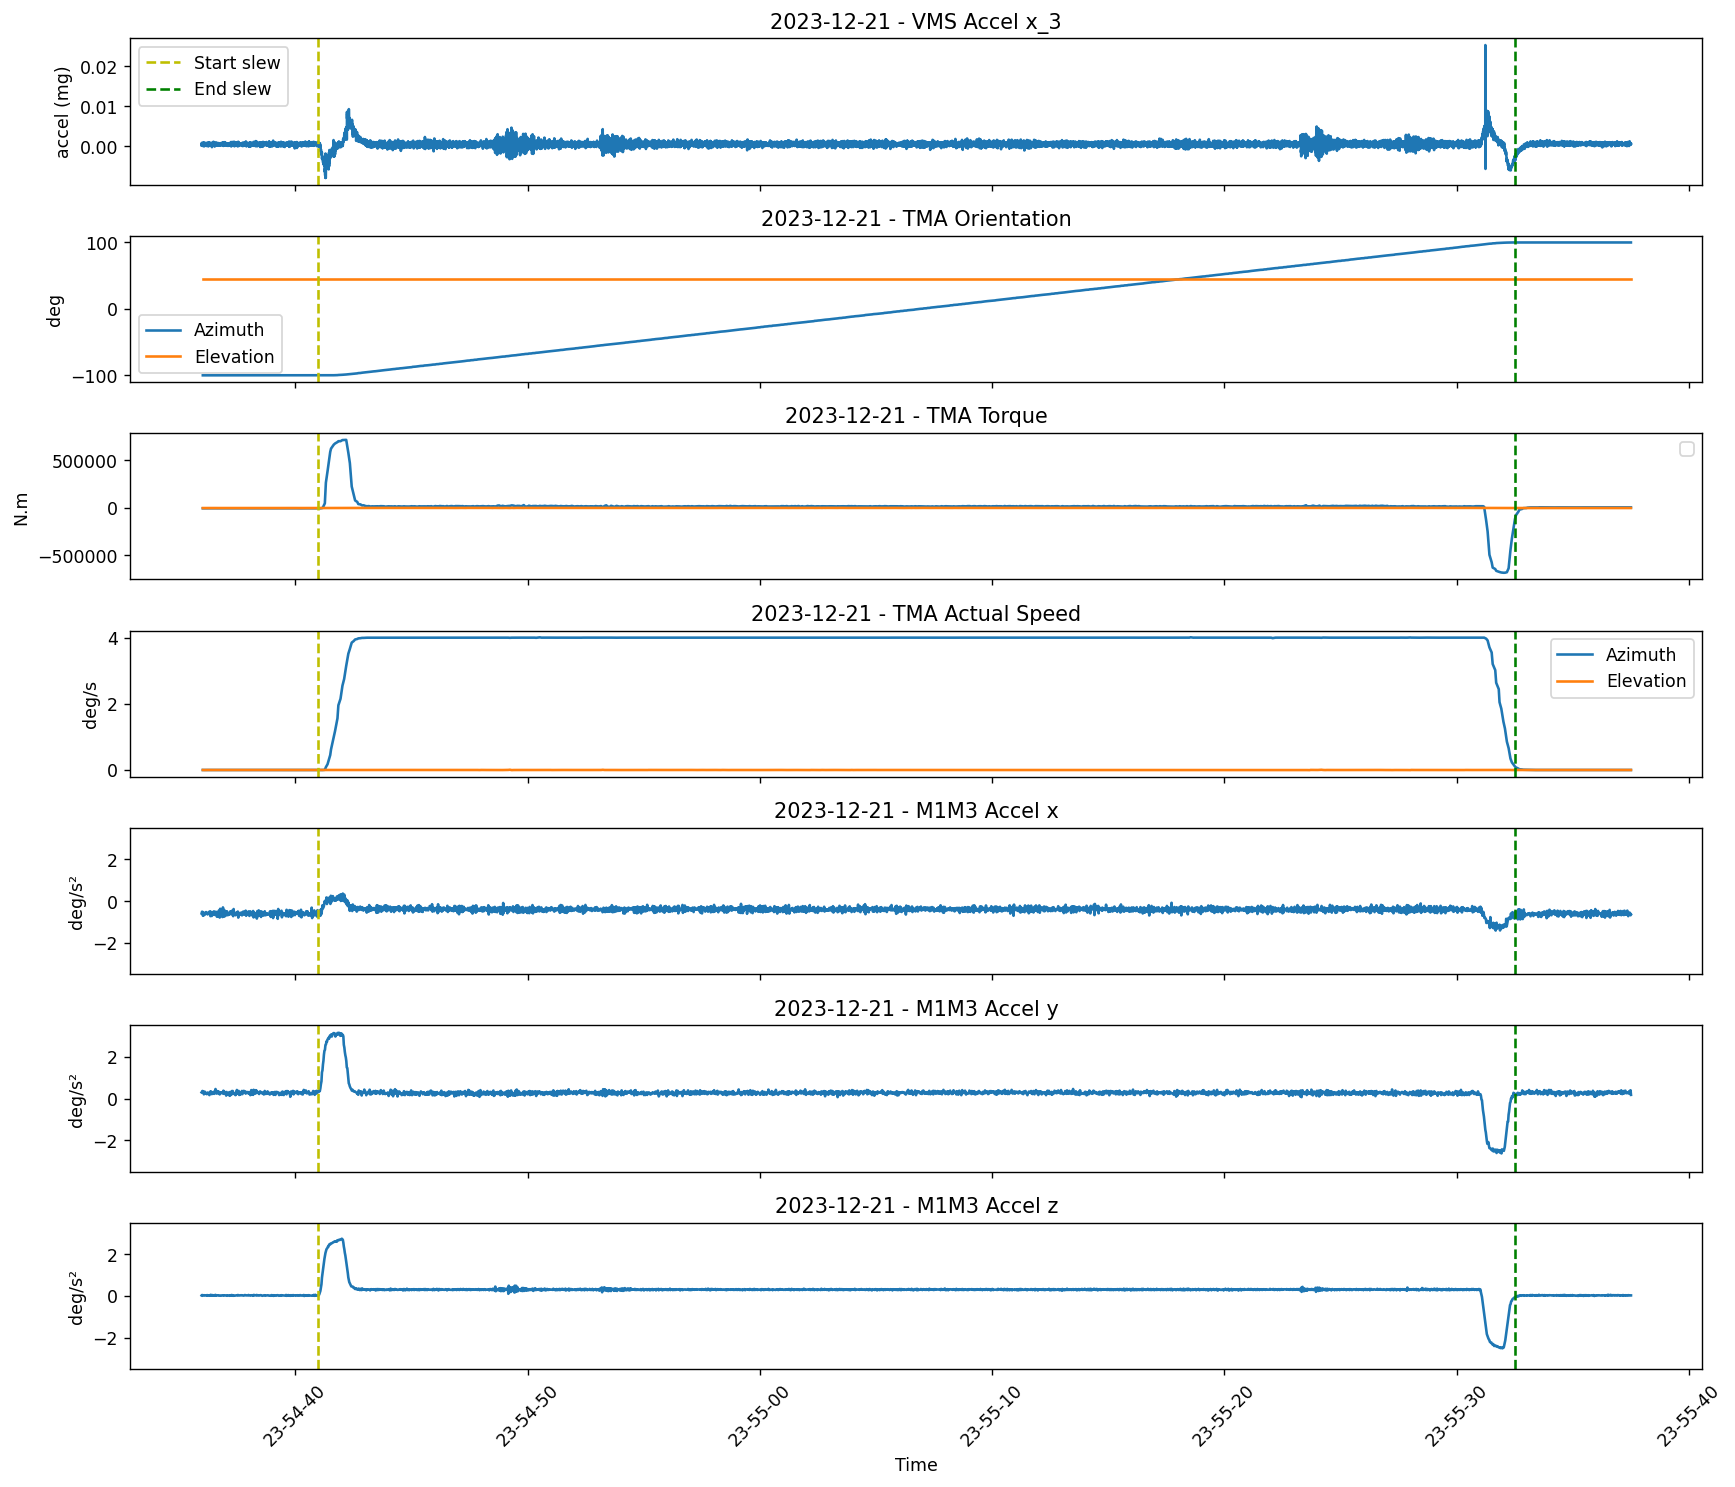

In [50]:
# Plot a few quantities to check that we have selected a good quality slew

fig, ax = plt.subplots(7, 1, sharex=True, dpi=125, figsize=(14, 12))
ax[0].plot(vms_m1m3_data["times"][sel], vms_m1m3_data["m1m3_x_3"][sel])
ax[0].set(ylabel="accel (mg)", title=f"{vms_date} - VMS Accel x_3")
ax[1].plot(df_azi.index, df_azi["actualPosition"], label="Azimuth")
ax[1].plot(df_ele.index, df_ele["actualPosition"], label="Elevation")
ax[1].legend()
ax[1].set(ylabel="deg", title=f"{vms_date} - TMA Orientation")
ax[2].plot(df_azi.index, df_azi["actualTorque"])
ax[2].plot(df_ele.index, df_ele["actualTorque"])
ax[2].set(ylabel="N.m", title=f"{vms_date} - TMA Torque")
ax[2].legend()
ax[3].plot(df_azi.index, df_azi["actualVelocity"], label="Azimuth")
ax[3].plot(df_ele.index, df_ele["actualVelocity"], label="Elevation")
ax[3].set(ylabel="deg/s", title=f"{vms_date} - TMA Actual Speed")
ax[3].legend()
ax[4].plot(df_accel.index, df_accel["angularAccelerationX"])
ax[4].set(ylabel="deg/s²", title=f"{vms_date} - M1M3 Accel x")
ax[4].set_ylim([-3.5, 3.5])
ax[5].plot(df_accel.index, df_accel["angularAccelerationY"])
ax[5].set(ylabel="deg/s²", title=f"{vms_date} - M1M3 Accel y")
ax[5].set_ylim([-3.5, 3.5])
ax[6].plot(df_accel.index, df_accel["angularAccelerationZ"])
ax[6].set(ylabel="deg/s²", title=f"{vms_date} - M1M3 Accel z")
ax[6].set_ylim([-3.5, 3.5])
ax[len(ax) - 1].set_xlabel("Time")
for i in range(len(ax)):
    ax[i].xaxis.set_major_formatter(DateFormatter("%H-%M-%S"))
    plt.setp(ax[i].get_xticklabels(), rotation=45)
    for ct, ev in enumerate(selected):
        if i == 0 and ct == 0:
            ax[i].axvline(ev.begin.datetime64, color="y", ls="--", label="Start slew")
            ax[i].axvline(ev.end.datetime64, color="g", ls="--", label="End slew")
            ax[0].legend()
        else:
            ax[i].axvline(ev.begin.datetime64, color="y", ls="--")
            ax[i].axvline(ev.end.datetime64, color="g", ls="--")
    if i == 0:
        ax[0].legend(loc="upper left")
fig.tight_layout()
fig.savefig(f"{plot_dir}/overview-{vms_date}-{slew_select}.png")

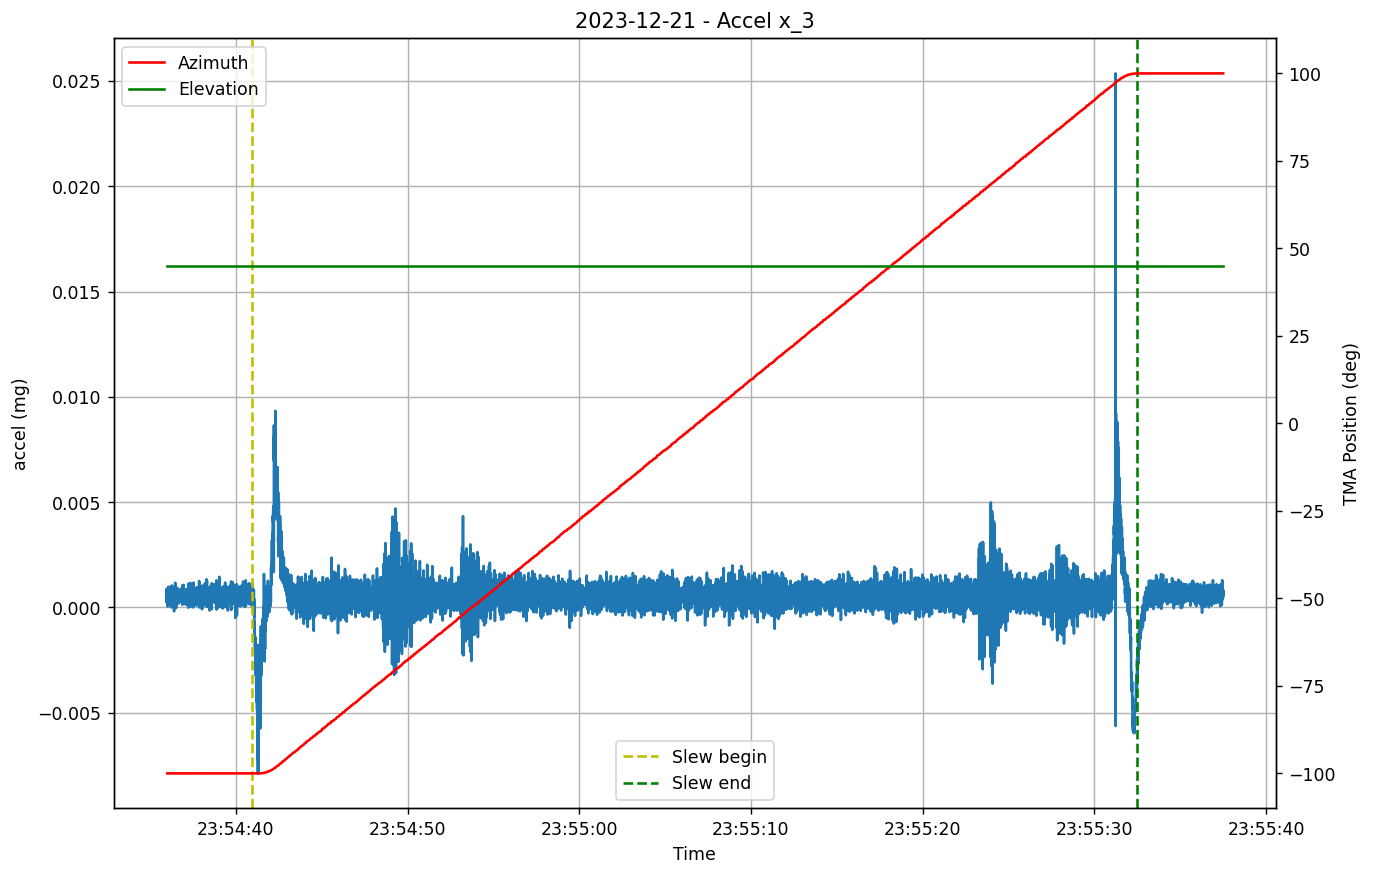

In [51]:
# Zoom in the acceleration measured by the VMS
fig, ax = plt.subplots(1, 1, dpi=125, figsize=(12, 8))
ax.plot(vms_m1m3_data["times"][sel], vms_m1m3_data["m1m3_x_3"][sel])
ax.set(ylabel="accel (mg)", xlabel="Time", title=f"{vms_date} - Accel x_3")
ax2 = ax.twinx()
ax2.plot(df_azi.index, df_azi["actualPosition"], c="red", label="Azimuth")
ax2.plot(df_ele.index, df_ele["actualPosition"], c="green", label="Elevation")
ax2.set_ylabel("TMA Position (deg)")
ax2.legend()
for i, ev in enumerate(selected):
    ax.axvline(ev.begin.datetime64, color="y", ls="--", label="Slew begin")
    ax.axvline(ev.end.datetime64, color="g", ls="--", label="Slew end")
    if i == 0:
        ax.legend()
ax.grid(axis="both")
fig.savefig(f"{plot_dir}/VMS-zoom-{vms_date}-{slew_select}.png")

We see that on top of the acceleration / deceleration phase the VMS is recording 4 sequences of vibrations (glitches) that occur while the TMA is rotating at constant speed.

## Check whether HP forces are correlated with VMS data

In [52]:
df_hp = getEfdData(
    client, "lsst.sal.MTM1M3.hardpointActuatorData", begin=start_slew, end=end_slew
)

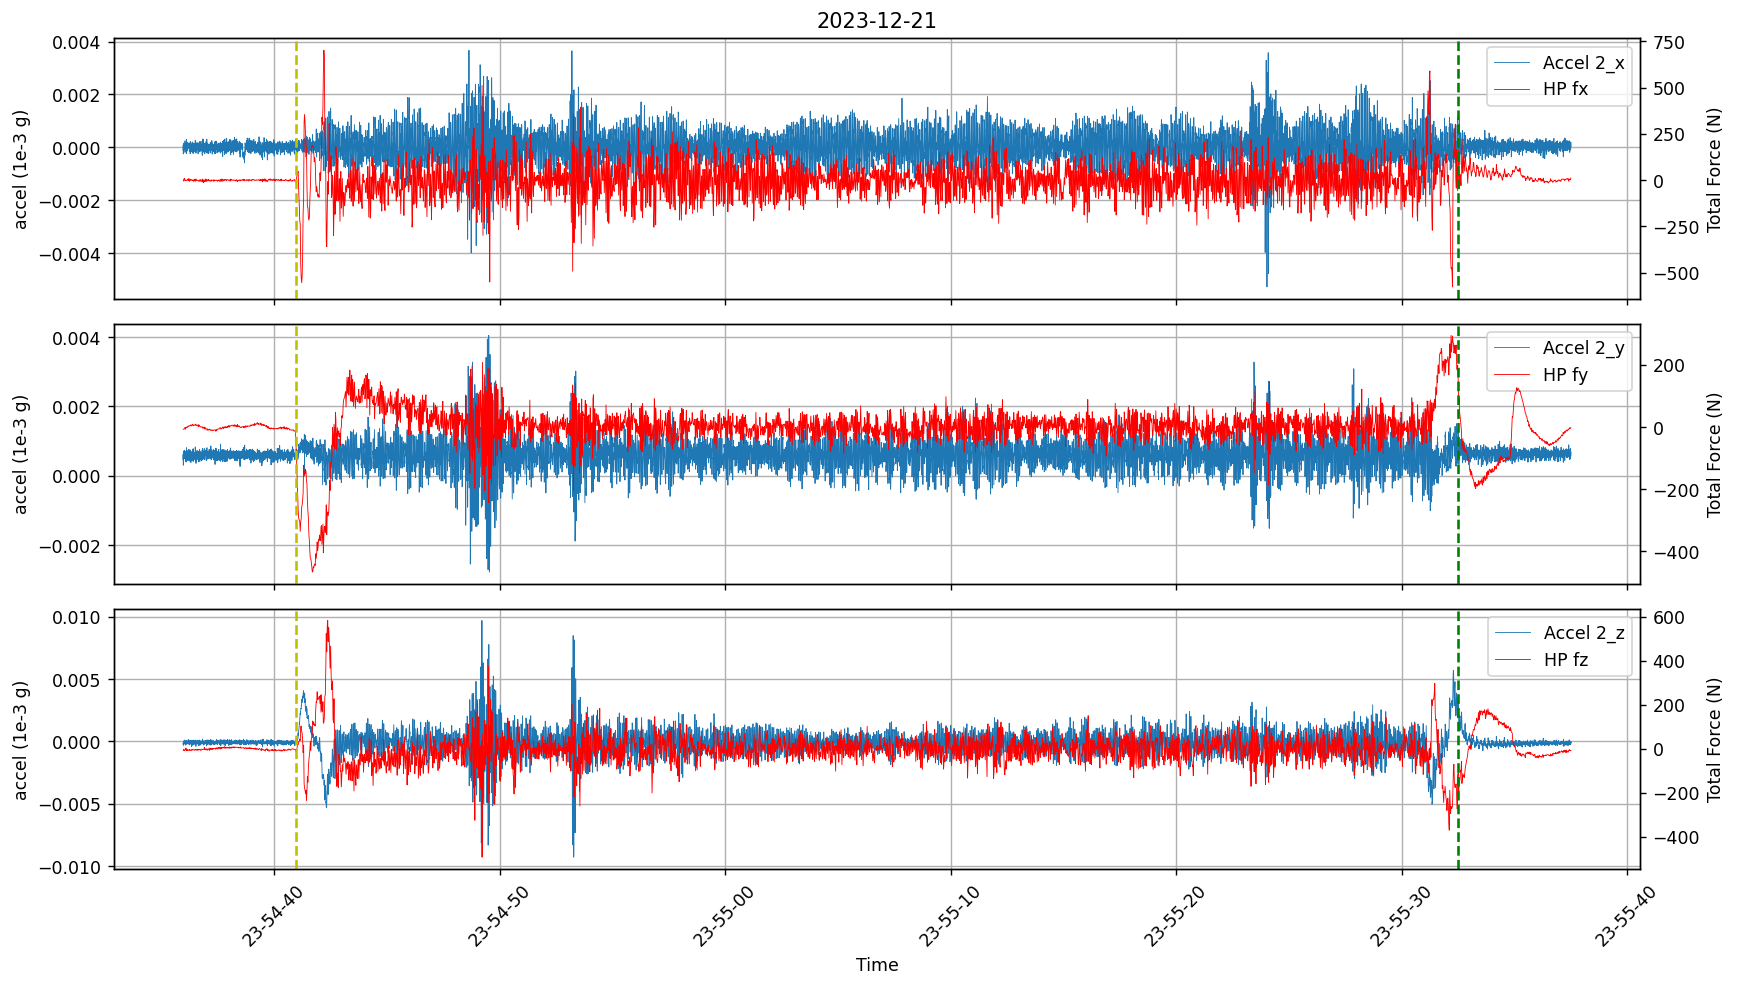

In [54]:
fig, ax = plt.subplots(3, 1, sharex=True, dpi=125, figsize=(14, 8))
bx = []
for i, axis in enumerate("xyz"):
    lns1 = ax[i].plot(
        vms_m1m3_data["times"][sel],
        vms_m1m3_data[f"m1m3_{axis}_2"][sel],
        lw=0.5,
        label=f"Accel 2_{axis}",
    )
    ax[i].set(ylabel="accel (1e-3 g)")
    bx.append(ax[i].twinx())
    lns2 = bx[i].plot(
        df_hp.index, df_hp[f"f{axis}"], c="red", lw=0.5, label=f"HP f{axis}"
    )
    bx[i].set_ylabel(f"Total Force (N)")
    ax[i].grid(axis="both")
    lns = lns1 + lns2
    labs = [l.get_label() for l in lns]
    ax[i].legend(lns, labs)
    for ct, ev in enumerate(selected):
        if i == 0 and ct == 0:
            bx[i].axvline(ev.begin.datetime64, color="y", ls="--", label="Start slew")
            bx[i].axvline(ev.end.datetime64, color="g", ls="--", label="End slew")
        else:
            bx[i].axvline(ev.begin.datetime64, color="y", ls="--")
            bx[i].axvline(ev.end.datetime64, color="g", ls="--")
ax[2].set(xlabel="Time")
ax[0].set(title=f"{vms_date}")
ax[2].xaxis.set_major_formatter(DateFormatter("%H-%M-%S"))
plt.setp(ax[i].get_xticklabels(), rotation=45)
fig.tight_layout()
fig.savefig(f"{plot_dir}/VMS-HP-{vms_date}-{slew_select}.png")

We see that the first 2 glitches around 23:54:50 are obvious in the HP forces, the 2 others around 23:55:25 are much less visible

### Find glitches in accelerometer data
In the following we are going to analyse the data from one axis of a single accelerometer in order to identify glitches
and locate the associated TMA positions

In [55]:
# We select the vms data corresponding to the slew duration cutting out the acceleration and deceleration phases

delta_t = TimeDelta(5, format="sec")
start_slew_strict = sel_slews[slew_select].begin + delta_t
end_slew_strict = sel_slews[slew_select].end - delta_t

sel_strict = (vms_m1m3_data["times"] > start_slew_strict.datetime64) & (
    vms_m1m3_data["times"] < end_slew_strict.datetime64
)

# We apply a high pass filter to remove the low frequency noise
sos = signal.butter(8, 20, "high", fs=200, output="sos")
filtered = signal.sosfilt(sos, vms_m1m3_data["m1m3_y_2"][sel_strict])

# We subtract the mean value and take the square of the signal in order to have positive values only
accel = (filtered - np.mean(filtered)) ** 2

In [56]:
# The VMS data are sampled at 200 Hz, so we rebin the signal in order to limit the
# fluctuations and reinforce the peaks.

accel_rebin = []
t_rebin = []
for p in range(0, len(accel), 20):
    sum = np.sum(accel[p : p + 20])
    accel_rebin.append(sum)
    if p + 9 < len(accel):
        t_rebin.append(vms_m1m3_data["times"][sel_strict].values[p + 9])
    else:
        t_rebin.append(vms_m1m3_data["times"][sel_strict].values[len(accel) - 1])

# We normalize the signal to 1
norm = np.max(accel_rebin)
accel_rebin = accel_rebin / norm

In [57]:
len(accel)

8310

In [58]:
# We detects the position of the peaks in the signal
peaks, _ = signal.find_peaks(accel_rebin, prominence=0.09, distance=5)
t_peak = [t_rebin[ll] for ll in peaks]
y_peak = np.full(len(t_peak), 0.8)
print(f"{len(t_peak)} peaks detected in signal")

6 peaks detected in signal


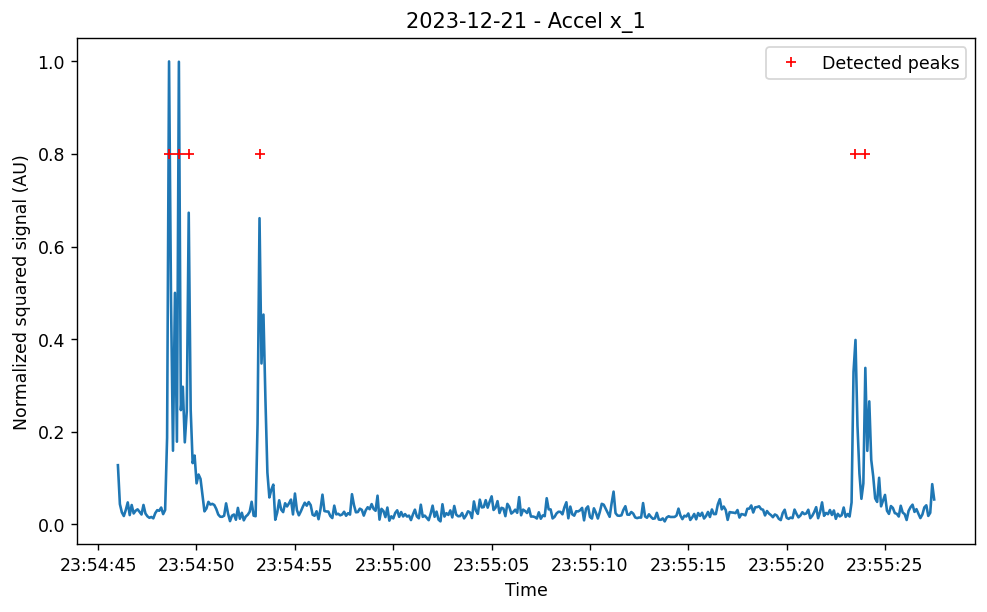

In [59]:
# We plot the signal and the detected peak positions in order to check
# that the peak detection makes sense
fig, ax = plt.subplots(1, 1, dpi=125, figsize=(8, 5))
ax.plot(t_rebin, accel_rebin)
ax.plot(t_peak, y_peak, "r+", label="Detected peaks")
ax.set_xlabel("Time")
ax.set_ylabel("Normalized squared signal (AU)")
ax.legend()
ax.set_title(f"{vms_date} - Accel x_1")
fig.tight_layout()
fig.savefig(f"{plot_dir}/VMS-peaks-{vms_date}-{slew_select}.png")

In [60]:
# We find the time stamps corresponding to the peaks
locate = df_azi.index.tz_localize(None).get_indexer(t_peak, method="nearest")

# We determine the TMA positions corresponding to the glitches
glitches_azi = [df_azi["actualPosition"].iloc[k] for k in locate]
glitches_ele = [df_ele["actualPosition"].iloc[k] for k in locate]

date = sel_slews[slew_select].begin.datetime.replace(microsecond=0)
seqNum = sel_slews[slew_select].seqNum
np.set_printoptions(precision=1)
print(f"\nStart date: {date} - seqNum: {seqNum} - slew number: {slew_select}")
print(
    f"Azimuth: {min_azi:.0f} : {max_azi:.0f} / Elevation: {min_ele:.0f} : {max_ele:.0f}"
)
print(f"TMA speed - Azimuth: {speed_azi:.0f} deg/s - Elevation: {speed_ele:.0f} deg/s")
print(f"Glitches correspond to the following TMA positions:")
print(f"    o in Azimuth:  {np.array(glitches_azi)} degrees")
print(f"    o and in Elevation: {np.array(glitches_ele)} degrees\n")


Start date: 2023-12-21 23:54:40 - seqNum: 91 - slew number: 558
Azimuth: -100 : 100 / Elevation: 45 : 45
TMA speed - Azimuth: 4 deg/s - Elevation: 0 deg/s
Glitches correspond to the following TMA positions:
    o in Azimuth:  [-73.1 -71.3 -69.1 -54.7  66.3  68.5] degrees
    o and in Elevation: [45. 45. 45. 45. 45. 45.] degrees



In [ ]:
fs = 200
f1, t1, Zxx1 = stft(filtered, fs, "hamming", 128, scaling="psd")

fig, ax = plt.subplots(1, 1, dpi=125, figsize=(8, 5))
pcm = ax.pcolormesh(
    t1, f1, np.abs(Zxx1), shading="gouraud", norm=matplotlib.colors.LogNorm()
)
fig.tight_layout()

In [ ]:
from scipy import signal

b, a = signal.butter(8, 50, "high", analog=True)
w, h = signal.freqs(b, a)

In [ ]:
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title("Butterworth filter frequency response")
plt.xlabel("Frequency [radians / second]")
plt.ylabel("Amplitude [dB]")
plt.margins(0, 0.1)
plt.grid(which="both", axis="both")
plt.axvline(100, color="green")  # cutoff frequency

In [ ]:
# Simple Fourier analysis

begin = sel_slews[slew_select].begin
end = sel_slews[slew_select].end

fig, ax = plt.subplots(3, 3, dpi=125, figsize=(12, 8))
for c in range(3):

    subdat_sel = (vms_m1m3_data["times"] > begin.datetime64) & (
        vms_m1m3_data["times"] < end.datetime64
    )
    subdat = vms_m1m3_data.loc[subdat_sel, :]
    for j, axis in enumerate("xyz"):
        key = f"m1m3_{axis}_{c+1}"
        norm_signal = np.int16((subdat[key] / subdat[key].max()) * 32767)
        sig_fft = rfft(norm_signal)
        sample_freq = rfftfreq(
            len(subdat[key]), np.mean(np.diff(Time(subdat["times"]).unix))
        )
        power = np.abs(sig_fft) ** 2

        # Cut the first bins in frequency to avoid the large peak close to 0 Hz
        ax[c][j].plot(sample_freq[2:], power[2:], lw=1)
        ax[c][j].set_xticks(np.arange(0, 110, 10))
        ax[c][j].set(
            ylabel="Power",
            xlabel="Frequency [Hz]",
            title=f"Sensor {c+1} - axis {axis}",
        )
        yticks = ticker.MaxNLocator(4)
        ax[c][j].yaxis.set_major_locator(yticks)
        xticks = ticker.MaxNLocator(6)
        ax[c][j].xaxis.set_major_locator(xticks)
        ax[c][j].set_xlim([0, 100])
        # ax[c][j].set_ylim([0, 1e-6])
        # ax[c][j].set_yscale("log")
# fig.suptitle(f"FCU speed: {percentv}%")
date = sel_slews[slew_select].begin.datetime.replace(microsecond=0)
seqNum = sel_slews[slew_select].seqNum
speed_azi = abs(df_azi["actualVelocity"]).max()
speed_ele = abs(df_ele["actualVelocity"]).max()
fig.suptitle(
    f"{date} - seqNum: {seqNum} - Speed Azi: {speed_azi:.1f} deg/s - Speed Ele: {speed_ele:.1f} deg/s"
)
fig.tight_layout()

* Accel 1 - x - Frq: [1.57, 7.78, 14.01, 15.56, 19.05, 31.11, 41.98, 42.77]
* Accel 1 - y - Frq: [1.53, 7.78, 14.01, 15.56, 16.33, 17.38, 19.46, 31.11]
* Accel 1 - z - Frq: [1.53, 14.01, 15.56]
* Accel 2 - x - Frq: [14.01, 15.56, 46.67]
* Accel 2 - y - Frq: [14.01, 15.56]
* Accel 2 - z - Frq: [14.01, 15.52, 19.48]
* Accel 3 - x - Frq: [1.57, 14.01, 15.56, 18.58, 19.46, 31.11, 41.98, 46.67]
* Accel 3 - y - Frq: [1.55, 14.01, 15.56, 19.01]
* Accel 3 - z - Frq: [1.55, 14.01, 15.56]


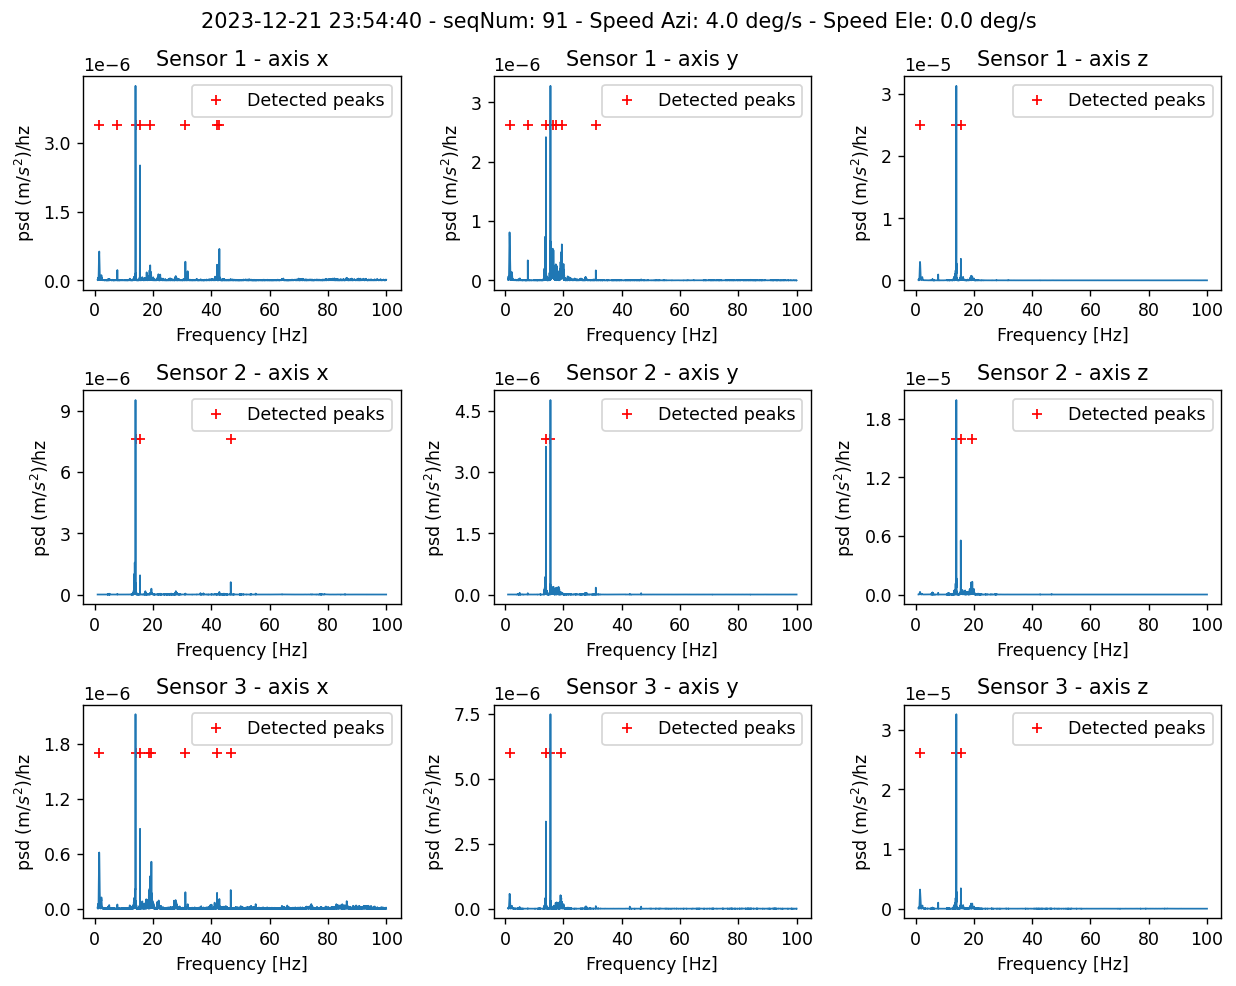

In [91]:
# PSD analysis

begin = sel_slews[slew_select].begin
end = sel_slews[slew_select].end

df_azi = getEfdData(
    client,
    "lsst.sal.MTMount.azimuth",
    begin=begin,
    end=end,
)
df_ele = getEfdData(
    client,
    "lsst.sal.MTMount.elevation",
    begin=begin,
    end=end,
)

fig, ax = plt.subplots(3, 3, dpi=125, figsize=(10, 8))
for c in range(3):

    subdat_sel = (vms_m1m3_data["times"] > begin.datetime64) & (
        vms_m1m3_data["times"] < end.datetime64
    )
    subdat = vms_m1m3_data.loc[subdat_sel, :]
    for j, axis in enumerate("xyz"):
        key = f"m1m3_{axis}_{c+1}"
        psds_df, disp = get_psd_and_dsd_for_vms(
            subdat[key],
            np.mean(np.diff(Time(subdat["times"]).unix)),
            g=True,
            min_freq=1,
        )

        x = psds_df["freq"]
        y = psds_df["accel_psd"]
        norm = np.max(y)
        y_norm = y / norm
        peaks, _ = signal.find_peaks(y_norm, prominence=0.05, distance=40)
        x_peaks = [x[p] for p in peaks]
        x_peaks_trunc = [float(f"{x[p]:.2f}") for p in peaks]
        y_peaks = np.full(len(x_peaks), 0.8 * norm)
        print(f"* Accel {c+1} - {axis} - Frq: {x_peaks_trunc}")
        ax[c][j].plot(x, y, zorder=9, lw=1)
        ax[c][j].set_xticks(np.arange(0, 110, 10))
        ax[c][j].set(
            ylabel="psd (m/$s^2$)/hz",
            xlabel="Frequency [Hz]",
            title=f"Sensor {c+1} - axis {axis}",
        )
        ax[c][j].plot(x_peaks, y_peaks, "r+", label="Detected peaks")
        yticks = ticker.MaxNLocator(4)
        ax[c][j].yaxis.set_major_locator(yticks)
        xticks = ticker.MaxNLocator(6)
        ax[c][j].xaxis.set_major_locator(xticks)
        ax[c][j].legend()
        # ax[c][j].set_ylim([0, 1e-5])
        # ax[c][j].set_ylim([0, 1e-6])
        # ax[c][j].set_yscale("log")
# fig.suptitle(f"FCU speed: {percentv}%")
date = sel_slews[slew_select].begin.datetime.replace(microsecond=0)
seqNum = sel_slews[slew_select].seqNum
speed_azi = abs(df_azi["actualVelocity"]).max()
speed_ele = abs(df_ele["actualVelocity"]).max()
fig.suptitle(
    f"{date} - seqNum: {seqNum} - Speed Azi: {speed_azi:.1f} deg/s - Speed Ele: {speed_ele:.1f} deg/s"
)
fig.tight_layout()
fig.savefig(f"{plot_dir}/psd-{vms_date}-{slew_select}-.png")

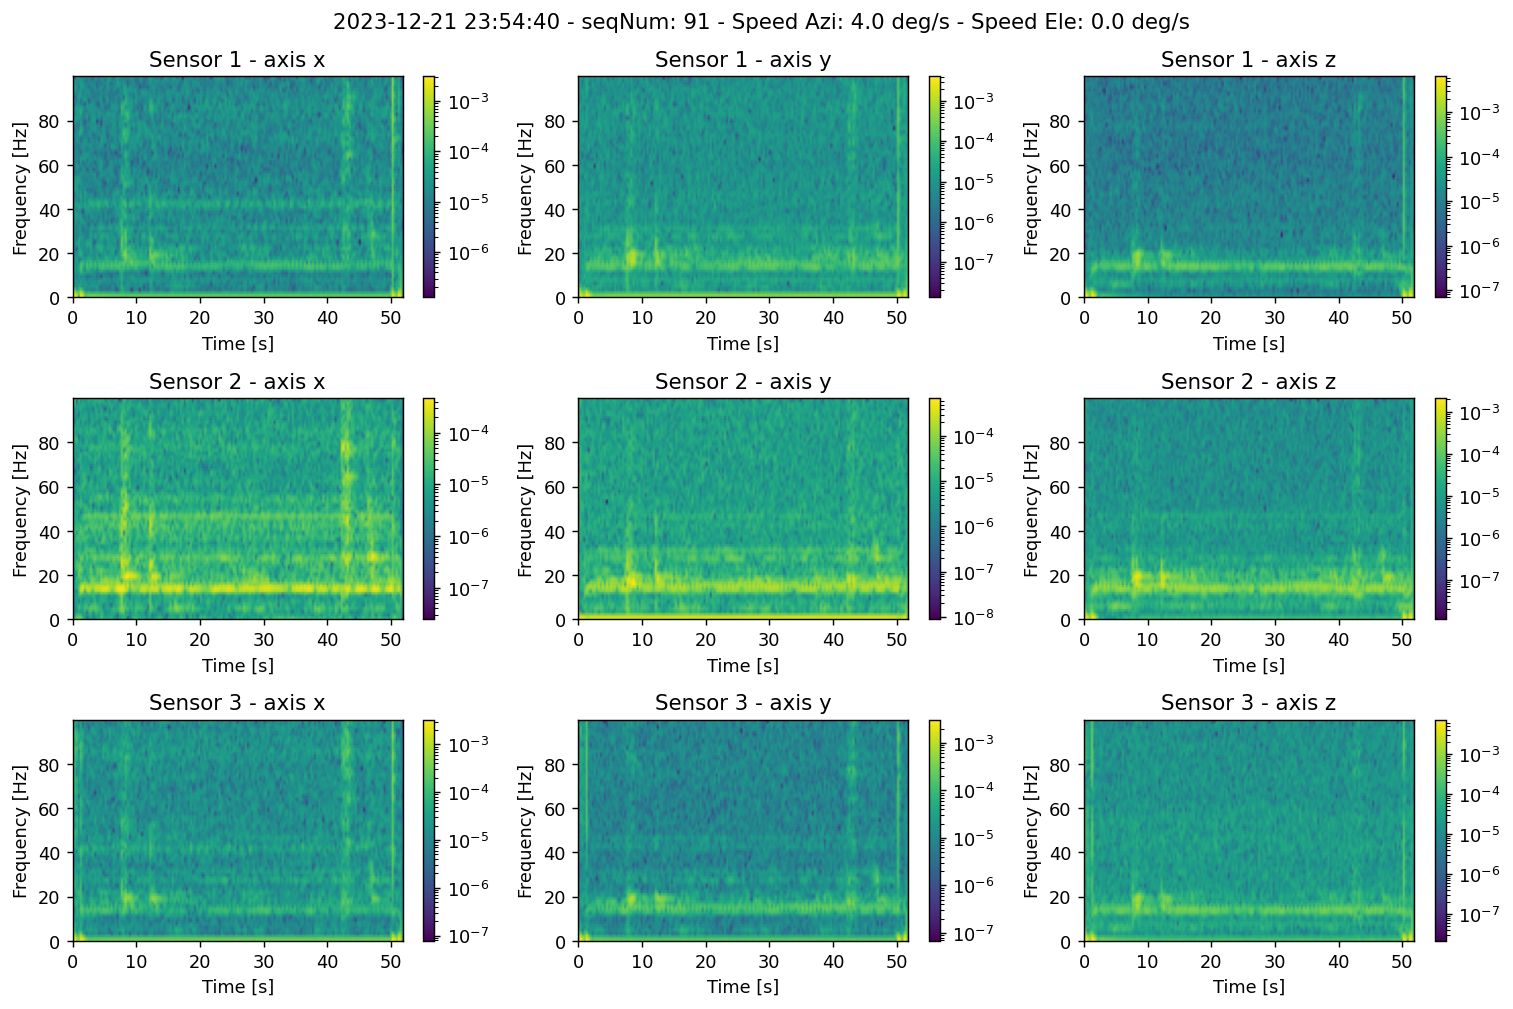

In [62]:
# Spectrograms

begin = sel_slews[slew_select].begin
end = sel_slews[slew_select].end

df_azi = getEfdData(
    client,
    "lsst.sal.MTMount.azimuth",
    begin=begin,
    end=end,
)
df_ele = getEfdData(
    client,
    "lsst.sal.MTMount.elevation",
    begin=begin,
    end=end,
)

fig, ax = plt.subplots(3, 3, dpi=128, figsize=(12, 8))
ax2 = ax
for c in range(3):

    subdat_sel = (vms_m1m3_data["times"] > begin.datetime64) & (
        vms_m1m3_data["times"] < end.datetime64
    )
    subdat = vms_m1m3_data.loc[subdat_sel, :]
    fs = 1 / np.mean(np.diff(Time(subdat["times"]).unix))
    for j, axis in enumerate("xyz"):
        key = f"m1m3_{axis}_{c+1}"

        f, t, Zxx = stft(subdat[key], fs, "hamming", 128, scaling="psd")

        pcm = ax[c][j].pcolormesh(
            t, f, np.abs(Zxx), shading="gouraud", norm=matplotlib.colors.LogNorm()
        )
        ax[c][j].set(
            xlabel="Time [s]",
            ylabel="Frequency [Hz]",
            title=f"Sensor {c+1} - axis {axis}",
        )
        fig.colorbar(pcm, ax=ax[c][j])

date = sel_slews[slew_select].begin.datetime.replace(microsecond=0)
seqNum = sel_slews[slew_select].seqNum
speed_azi = abs(df_azi["actualVelocity"]).max()
speed_ele = abs(df_ele["actualVelocity"]).max()
fig.suptitle(
    f"{date} - seqNum: {seqNum} - Speed Azi: {speed_azi:.1f} deg/s - Speed Ele: {speed_ele:.1f} deg/s"
)
fig.tight_layout()
fig.savefig(f"{plot_dir}/spectrogram-{vms_date}-{slew_select}.png")

We see that the glitches appear has vertical lines in the spectrogram extending from ~20 Hz up to ~80-100 Hz

## Analyze tracking events

In [95]:
# Find events durint which the TMA is in tracking mode
tracks = [e for e in events if e.type == TMAState.TRACKING]
print(f"We found {len(tracks)} events where the TMA is in tracking mode")

We found 617 events where the TMA is in tracking mode


In [96]:
# Filter the list of tracks in order to keep the ones that are fully contained within the day corresponding to the hdf5 file.
date_min = Time(f"{vms_date} 00:00:00.00").unix
date_end = Time(f"{vms_date} 23:59:59.00").unix
sel_tracks = [
    tracks[i]
    for i in range(len(tracks))
    if (tracks[i].begin.unix > date_min and tracks[i].end.unix < date_end)
]
print(f"Selected {len(sel_tracks)} tracks out of {len(tracks)} for {dayObs}")

Selected 231 tracks out of 617 for 20231221


In [124]:
# This is the track that we are going to analyze
track_select = 220
print(f"Tracking during {sel_tracks[track_select].duration:.1f} seconds")
seqNum = sel_tracks[track_select].seqNum

# Get rid of a small delta_t before and after the selected slew in order to be sure that the TMA is settled
delta_t = TimeDelta(5, format="sec")
start_track = sel_tracks[track_select].begin + delta_t
end_track = sel_tracks[track_select].end - delta_t
print(f"Selected track - start: {start_track.datetime64} - end: {end_track.datetime64}")

Tracking during 42.0 seconds
Selected track - start: 2023-12-21T04:10:28.560689688 - end: 2023-12-21T04:11:00.575988531


In [117]:
sel_t = (vms_m1m3_data["times"] > start_track.datetime64) & (
    vms_m1m3_data["times"] < end_track.datetime64
)

In [118]:
df_azi = getEfdData(
    client, "lsst.sal.MTMount.azimuth", begin=start_track, end=end_track
)
df_ele = getEfdData(
    client, "lsst.sal.MTMount.elevation", begin=start_track, end=end_track
)
print(len(df_azi), len(df_ele))

356 356


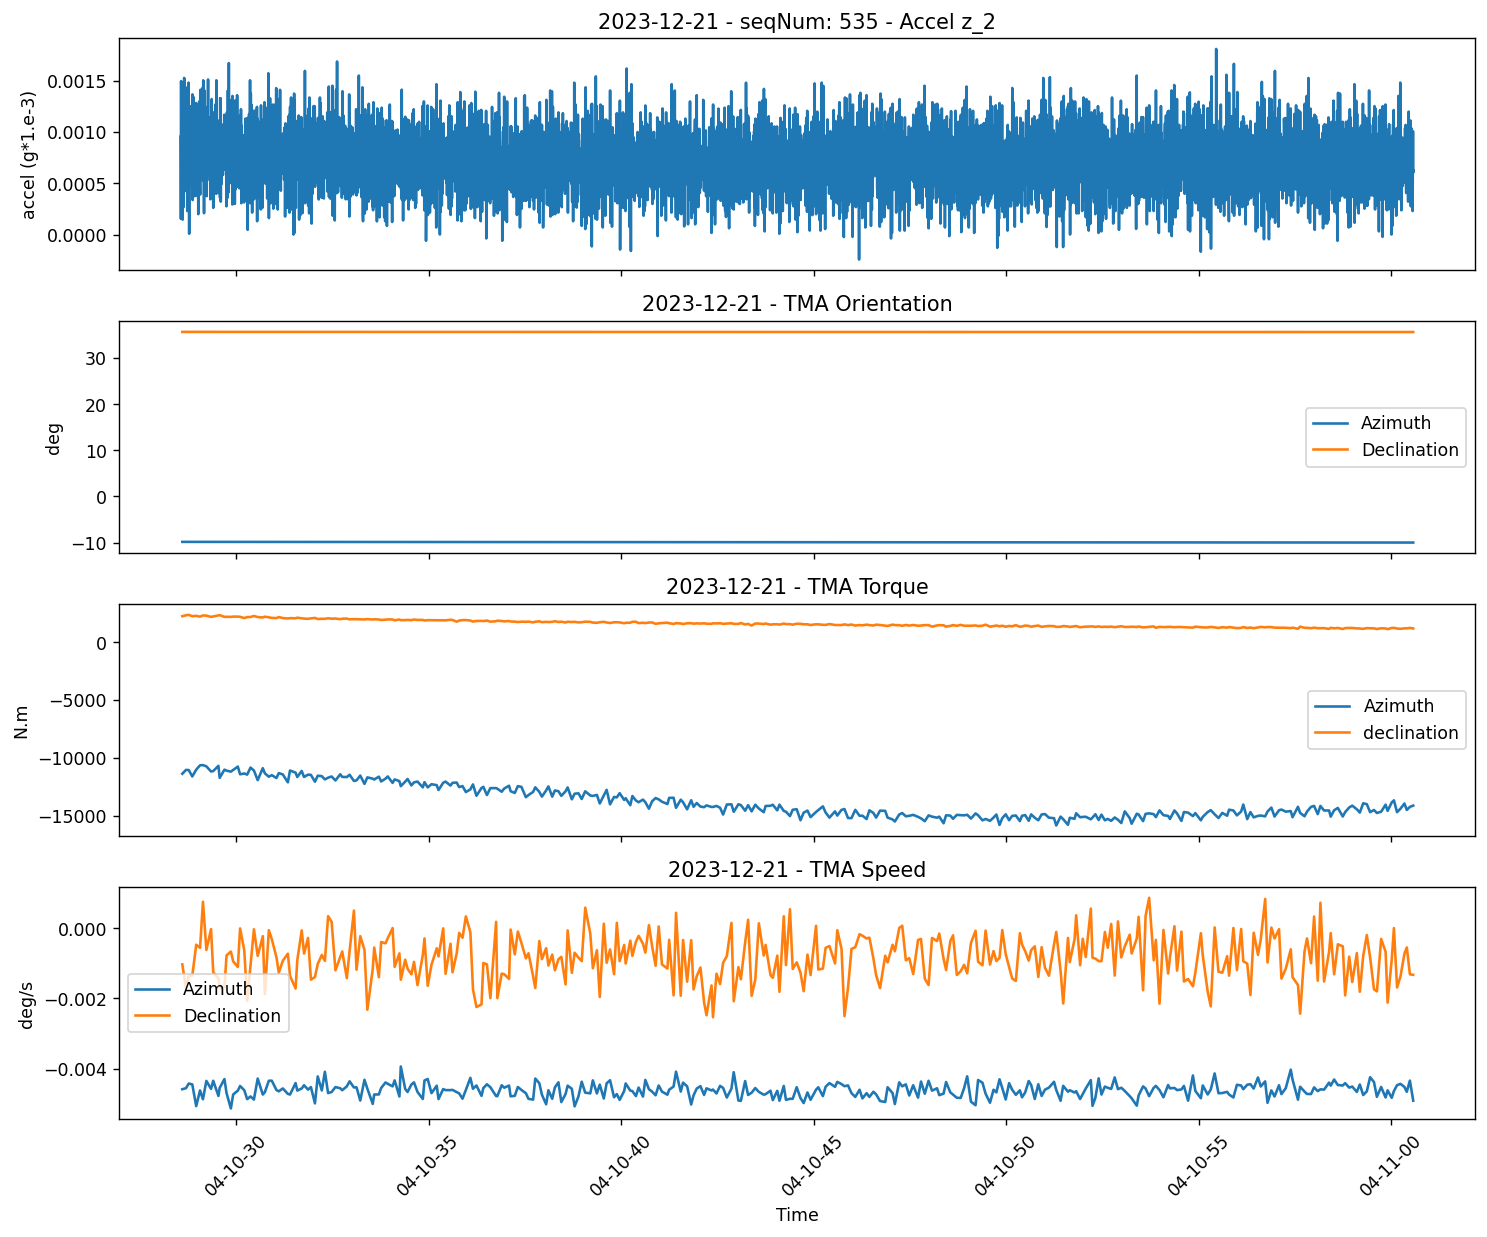

In [128]:
# Plot a few quantities to check that we have selected a good quality slew

fig, ax = plt.subplots(4, 1, sharex=True, dpi=125, figsize=(12, 10))
ax[0].plot(vms_m1m3_data["times"][sel_t], vms_m1m3_data["m1m3_x_3"][sel_t])
ax[0].set(ylabel="accel (g*1.e-3)", title=f"{vms_date} - seqNum: {seqNum} - Accel z_2")
ax[1].plot(df_azi.index, df_azi["actualPosition"], label="Azimuth")
ax[1].plot(df_ele.index, df_ele["actualPosition"], label="Declination")
ax[1].legend()
ax[1].set(ylabel="deg", title=f"{vms_date} - TMA Orientation")
ax[2].plot(df_azi.index, df_azi["actualTorque"], label="Azimuth")
ax[2].plot(df_azi.index, df_ele["actualTorque"], label="declination")
ax[2].set(ylabel="N.m", title=f"{vms_date} - TMA Torque")
ax[2].legend()
ax[3].plot(df_azi.index, df_azi["actualVelocity"], label="Azimuth")
ax[3].plot(df_ele.index, df_ele["actualVelocity"], label="Declination")
ax[3].set(ylabel="deg/s", xlabel="Time", title=f"{vms_date} - TMA Speed")
ax[3].legend()
for i in range(4):
    ax[i].xaxis.set_major_formatter(DateFormatter("%H-%M-%S"))
    plt.setp(ax[i].get_xticklabels(), rotation=45)
fig.tight_layout()
fig.savefig(f"{plot_dir}/overview-tracking-{vms_date}-{track_select}.png")

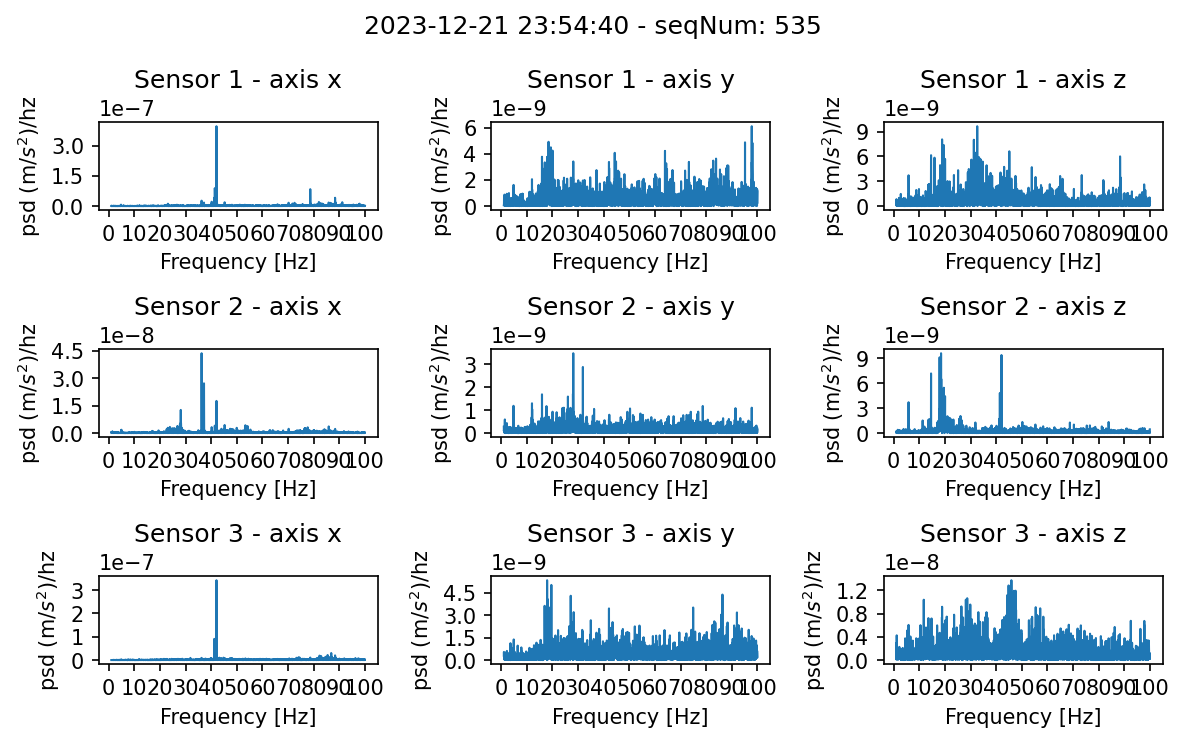

In [129]:
begin = start_track
end = end_track

fig, ax = plt.subplots(3, 3, dpi=150, figsize=(8, 5))
for c in range(3):

    subdat_sel = (vms_m1m3_data["times"] > begin.datetime64) & (
        vms_m1m3_data["times"] < end.datetime64
    )
    subdat = vms_m1m3_data.loc[subdat_sel, :]
    for j, axis in enumerate("xyz"):
        key = f"m1m3_{axis}_{c+1}"
        psds_df, disp = get_psd_and_dsd_for_vms(
            subdat[key],
            np.mean(np.diff(Time(subdat["times"]).unix)),
            g=True,
            min_freq=1,
        )

        x = psds_df["freq"]
        y = psds_df["accel_psd"]
        ax[c][j].plot(x, y, zorder=9, lw=1)
        ax[c][j].set_xticks(np.arange(0, 110, 10))
        ax[c][j].set(
            ylabel="psd (m/$s^2$)/hz",
            xlabel="Frequency [Hz]",
            title=f"Sensor {c+1} - axis {axis}",
        )
        yticks = ticker.MaxNLocator(4)
        ax[c][j].yaxis.set_major_locator(yticks)
fig.suptitle(f"{date} - seqNum: {seqNum}")
fig.tight_layout()
fig.savefig(f"{plot_dir}/psd-tracking-{vms_date}-{track_select}.png")